In [12]:
from typing import TypedDict

from dotenv import find_dotenv, load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage, AIMessage

In [13]:
load_dotenv(find_dotenv())

True

In [14]:
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
tool = [TavilySearchResults(max_results=1, topic="general")]
llm_with_tool = llm.bind_tools(tool)

In [15]:
class ResearchState(TypedDict):
    research_topic: str
    searched_output: str
    messages: list

In [30]:
def search_topic(state: ResearchState):
    print(f"Search topic: {state['research_topic']}")
    prompt = f"""
You are a intelligent research assistant which searches on the internet on a below given topic. The search result should be of 2-3 lines summary and less than 300 words. Capture the main points, no need to capture the whole sentences. This summary will be consumed by someone who will creates final report out of it. So it is vital for you to capture the essence of the topic and ignore any fluff.

NOTE: If you are not able to run the available tool(s), the reply with best of your knowledge

\n\n Search Topic: {state["research_topic"]}
"""
    # messages = [HumanMessage(content=prompt)]
    response = llm_with_tool.invoke(prompt)

    return {"searched_output": response.content, "messages": [response]}

In [31]:
def create_search_graph():
    graph = StateGraph(state_schema=ResearchState)
    graph.add_node("search_agent", search_topic)
    graph.add_node('tools', ToolNode(tools=tool))
    graph.add_edge(START, "search_agent")
    graph.add_edge("search_agent", 'tools')
    graph.add_conditional_edges(
        'search_agent',
        tools_condition
    )
    graph.add_edge("search_agent", END)

    return graph.compile()

In [32]:
workflow = create_search_graph()

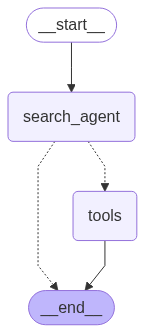

In [33]:
workflow

In [34]:
messages = workflow.invoke({'research_topic': HumanMessage(content="GPT-5 Launch")})

Search topic: content='GPT-5 Launch' additional_kwargs={} response_metadata={}


In [35]:
for message in messages["messages"]:
    message.pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Everything you should know about GPT-5 [August 2025] - Botpress", "url": "https://botpress.com/blog/everything-you-should-know-about-gpt-5", "content": "After months of speculation, OpenAI officially announced the GPT-5 launch on August 6, 2025, with a cryptic teaser posted on X (formerly Twitter):\n\n> LIVE5TREAM THURSDAY 10AM PT\n> \n> — OpenAI (@OpenAI) August 6, 2025\n\nThe “5” in the livestream title was the only confirmation needed — it marked the arrival of GPT-5. Just 24 hours later, on August 7 at 10am PT, OpenAI began rolling out GPT-5 across ChatGPT, the API, and the GitHub Models Playground. [...] What is GPT-5?\n--------------\n\nGPT-5 is OpenAI’s latest-generation large language model, officially released on August 7, 2025. It builds on the GPT architecture while integrating advancements fromreasoning-first models like o1 and o3.\n\nBefore GPT-5, 